In [47]:
# TODO B delete some of these


import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import networkx as nx

import scipy
import csv

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import json
import community as community_louvain
from copy import deepcopy
# from modularity_maximization.utils import get_modularity

from itertools import product
import networkx.algorithms.community as nx_comm
from scipy.spatial.distance import pdist, squareform

from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame

import math
from time import time

import matplotlib.lines as lines

## %matplotlib inline
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data

In [48]:
# edgelists
mobility = pd.read_csv("../data/usageousers_city_mobility_CT_networks.rpt.gz")
follow_hh = pd.read_csv("../data/usageousers_city_follower_CT_HH_networks.rpt.gz")

cbsacode = pd.read_csv("../data/cbsacode_shortname_tracts.csv",sep=";", index_col=0)

# reading in the master dataset about graphs
tract_df = pd.read_csv('../data/network_properties.csv') ### PAY ATTENTION TRACT INSTEAD OF TRACTS!!!!
# new versionwithout two degrees - old: graph_properties

# reading geojson data, converting it to geopandas dataframe
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/censustract_geoms_top50.geojson').readlines()]
)

# Cartesian coordinate projection of tract centroids
tract_geoms['centroid'] = tract_geoms['geometry'].centroid
tract_center_dict = tract_geoms\
    .set_geometry('centroid',crs={'init':'epsg:4326'})\
    .to_crs({'init':'epsg:3785'})\
    .set_index('full_geoid')['centroid'].map(lambda p: p.coords[0]).to_dict()

counties = gpd.read_file('../data/tl_2012_us_county.shp') # KERDES

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [49]:
# add city names to edgelists
cbsacode['city'] = cbsacode["short_name"].map(lambda s: s.split("/")[0].replace(' ','_').replace('.','').lower())
mobility = pd.merge(mobility, cbsacode[['geoid', 'city','short_name']], left_on = 'tract_home', right_on = 'geoid')
mobility = mobility.drop(columns = ['geoid'])
follow_hh = pd.merge(follow_hh, cbsacode[['geoid', 'city','short_name']], left_on = 'tract_home', right_on = 'geoid')
follow_hh = follow_hh.drop(columns = ['geoid'])
follow_hh = follow_hh.rename(columns={"tract_home.1": "tract_home_1"})

In [50]:
# adding normal city names
city_dict = dict(zip(cbsacode['city'],cbsacode['short_name']))
tract_df['short_name'] = tract_df['city'].map(city_dict)

In [51]:
# merge networks and coodrdinates

mobility = pd.merge(mobility,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_home', right_on='full_geoid',how='left') # on home
mobility = mobility.drop(columns='full_geoid')
mobility = mobility.rename(columns={"centroid": "centroid_home", "geometry": "polygon_home"})

mobility = pd.merge(mobility,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_work', right_on='full_geoid',how='left') # on work
mobility = mobility.drop(columns='full_geoid')
mobility = mobility.rename(columns={"centroid": "centroid_work", "geometry": "polygon_work"})

follow_hh = pd.merge(follow_hh,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_home', right_on='full_geoid',how='left') # on home_0
follow_hh = follow_hh.drop(columns='full_geoid')
follow_hh = follow_hh.rename(columns={"centroid": "centroid_home", "geometry": "polygon_home"})

follow_hh = pd.merge(follow_hh,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_home_1', right_on='full_geoid',how='left') # on home_1
follow_hh = follow_hh.drop(columns='full_geoid')
follow_hh = follow_hh.rename(columns={"centroid": "centroid_home_1", "geometry": "polygon_home_1"})

In [52]:
# colors
colors_fol_hh_ms = ['#7f3b08','#b35806','#e08214','#fdb863','#d8daeb','#b2abd2','#8073ac','#542788','#2d004b']
colors_fol_hh_mgn = ['#7f3b08','#b35806','#e08214','#fdb863','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b'] # modified
color_mob = '#2d004b'
color_mob_2 = '#8073ac'
color_fol_hh = '#00441b'
color_fol_hh_2 = '#5aae61'

# Functions

In [109]:
# Consensus community map drawer
def community_map(city, g_type, tract_df):
    """
    For a given network and algorithm used for calculating communities,
    it draws the colored community map eith tract boundaries.
    
    It uses the previously loaded `tract_geoms` GeoDataFrame in which geometrical data is stored,
    and `tract_df` pandas.DataFrames, in which consensus clustering labels are stored.
    
    Parameters:
    -----------
    city : str
        name of the city, lowercase, '_' instead of ' '
        
    g_type : str
        either "mob" as mobility or "fol_hh" as follow_hh 
        selects the type of graph to return
        
    algorithm_type : str
        either 'ms' as clustering (community finding) based on Expert et al.(2011) whose clustering algorithm uses a spatial null model
        or 'mgn' as clustering based on Newman-Girwan algortihm (which equals the Louvain)
        
    tract_df : pd.DataFrame
        contains community labels for each tract
        
    Returns:
    --------
    
    plot the map and save it to figures
        
    """
    
    # filter data to the given network's given communities
    map_df = deepcopy(tract_df[ (tract_df['city'] == city) & (tract_df['g_type'] == g_type)])
    # merge to geodata
    map_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], map_df, left_on='full_geoid', right_on='geoid')
    
    ##colors = colors_fol_hh_ms if algorithm_type == 'ms' else colors_fol_hh_mgn if algorithm_type == 'mgn' else 0 # else is mandatory
    ##cmap = matplotlib.colors.ListedColormap(colors)
    
    # colormap - uses 9 colors <-- this is the number of communities in the network with most communities
    #cmap = matplotlib.colors.ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'])
        
        ##['#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837']) lila - zold
        
        #['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999'])
    
    
    f, ax = plt.subplots(1,2, figsize=(32,16))
    f.suptitle(city, fontsize = 20)
    
    
    # Newman-Girwan
    map_tracts_mgn = deepcopy(map_tracts[map_tracts['algorithm_type'] == 'mgn'])
    cmap = matplotlib.colors.ListedColormap(colors_fol_hh_mgn)
    map_tracts_mgn.plot(ax=ax[0], column = 'S_cons', cmap=cmap, legend=True)
    map_tracts.boundary.plot(ax=ax[0], color='black', linewidth=0.015)
    #map_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
    ax[0].set_axis_off()
    
    # Spatial a la Expert
    map_tracts_ms = deepcopy(map_tracts[map_tracts['algorithm_type'] == 'ms'])
    # SAME cmap = matplotlib.colors.ListedColormap(colors_fol_hh_ms)
    map_tracts_ms.plot(ax=ax[1], column = 'S_cons', cmap=cmap, legend=True)
    map_tracts.boundary.plot(ax=ax[1], color='black', linewidth=0.015)
    #map_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
    ax[1].set_axis_off()
    
    plt.show()
    

In [102]:
    if algorithm_type == 'ms':
        alg = 'Expert et al.(2011) algorithm'
    elif algorithm_type == 'mgn':
            alg = 'Newman-Girvan algorithm'
    title = city + 's communities using ' + alg # KERDES apostroph
    plt.title(title, size = 20)
    plt.show()
    filename = 'consen_communities_' + 'city' + '_' + g_type + '_' + algorithm_type
    # savefig(filename, dpi=1200, bbox_inches='tight')

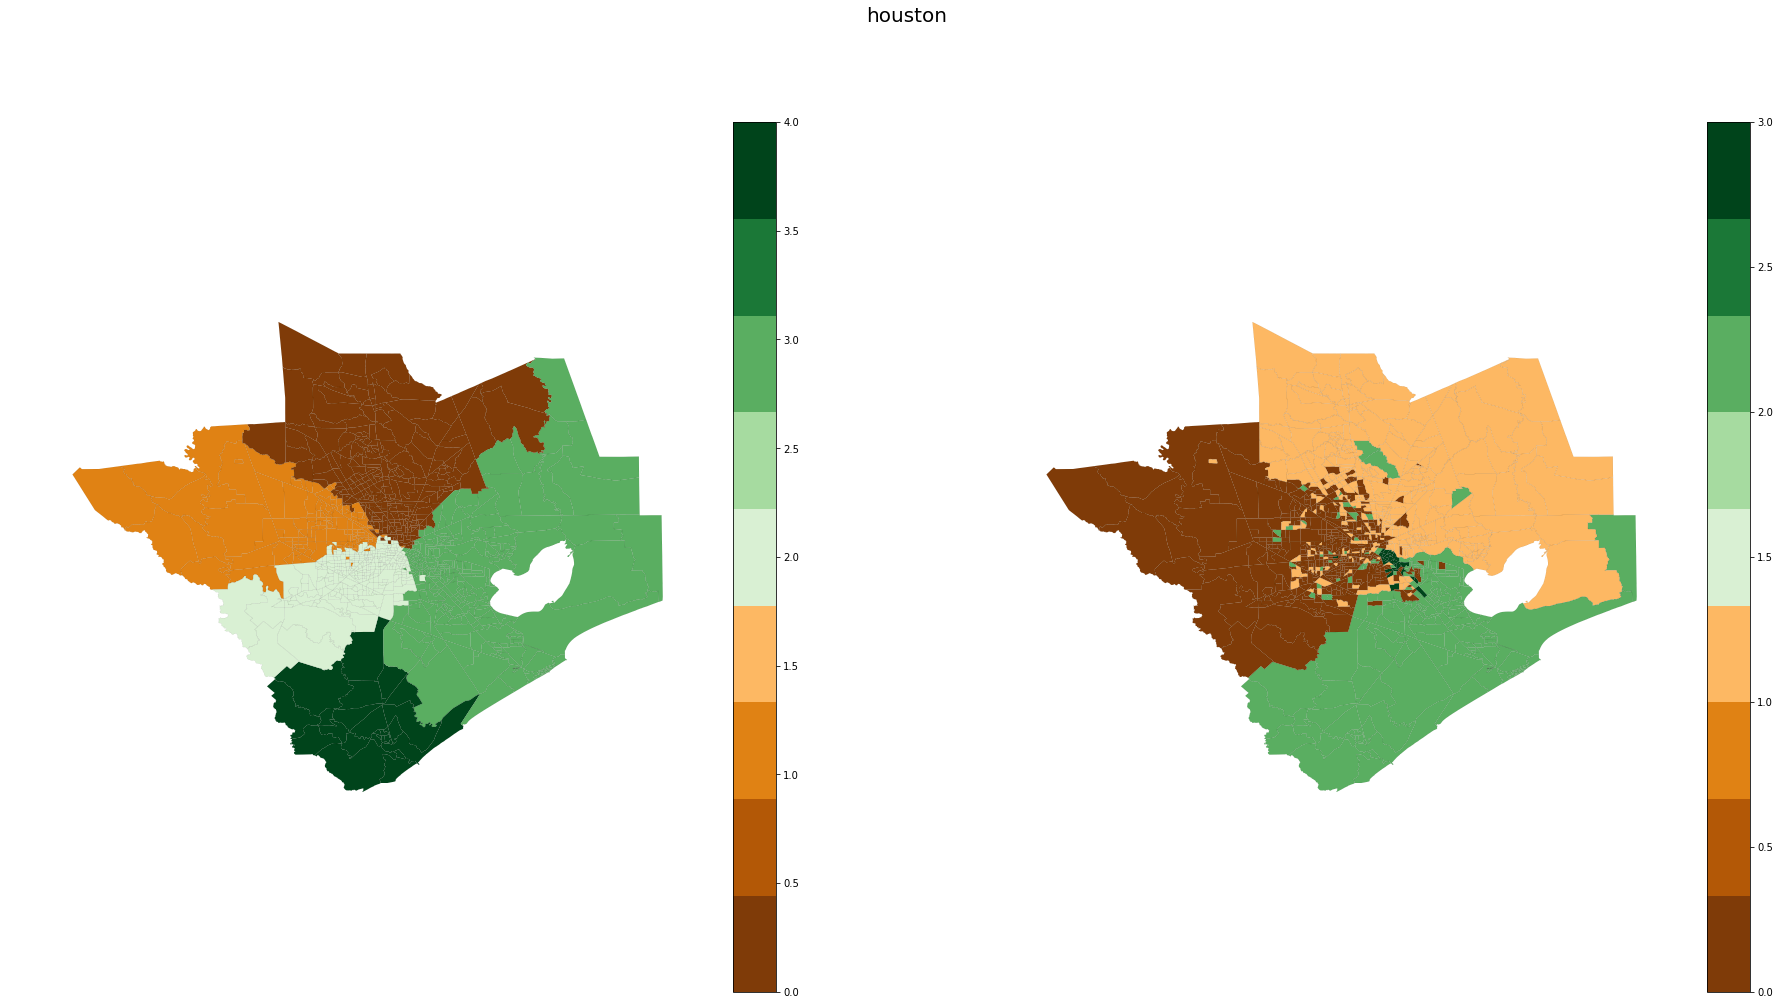

In [110]:
community_map('houston','mob', tract_df)

### Degree distribution

In [55]:
def degree_dist_histograms(city):
    
    """
    For a given city draws the degree distribution histograms.
    
    It uses the previously loaded `tract_df` pandas.DataFrame in which degree data is stored for each tract.
    
    Parameters:
    -----------
    city : str
        name of the city, in the form of cbsacode['short_name']
        ex: 'Salt Lake City'
        
    Returns:
    --------
    
    plot two histograms on eachother and save it to figures
        
    """
    
    plt.subplots(1,1,figsize=(8, 6))
    
    title = 'Degree distribution of tracts in ' + city
    plt.title(title, fontsize = 18)
    
    # data to plot
    degree_mob = tract_df[(tract_df['g_type'] == 'mob') & (tract_df['short_name'] == city)]['degree']
    degree_fol_hh = tract_df[(tract_df['g_type'] == 'fol_hh') & (tract_df['short_name'] == city)]['degree']

    #histogram
    bins = np.linspace(0, max(max(degree_mob), max(degree_fol_hh)), num = 50) # 50 bins 0 to max_degree
    mob , _ = np.histogram(degree_mob, bins=bins)
    fol_hh , _ = np.histogram(degree_fol_hh, bins=bins)
    
    # plot histogram
    plt.plot(bins[1:], mob, label = 'Mobility', marker='.', linewidth = 2, color = color_mob)
    plt.plot(bins[1:], fol_hh, label = 'Follower', marker='.', linewidth = 2, color = color_fol_hh)
    
    plt.xlabel('Degree', size = 16)
    plt.ylabel('No. tracts', size = 16)
    plt.legend(loc='upper right', fontsize = 14)
    plt.grid()
    plt.show()

    figname = 'degree_dist_' + city
    # savefig(figname, dpi=1200, bbox_inches='tight')

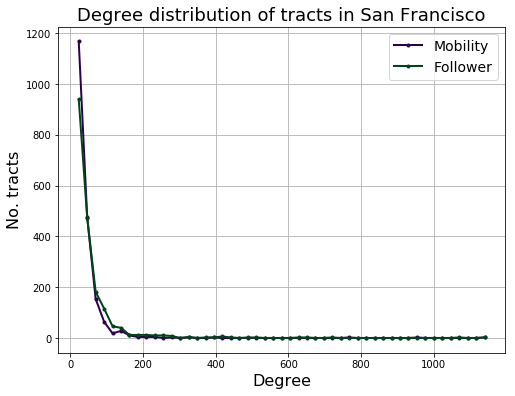

In [56]:
degree_dist_histograms('San Francisco')

# Bubble maps

In [57]:
# Create node weights for drawing the bubbles
# add up the weight from both sides of the edge

# Follower home-home
#set(follow_hh['tract_home']) - set(follow_hh['tract_home_1']) # empthy --> all the tracts which are home tracts a listed as tract_homes, so it is enoough to add up the weights for the one (of two) ways(s)

# check --> it was necessary as these are different
##set(follow_hh['cnt']*2 - follow_hh['all_home_cnt'])
fol_home_cnt_dict = dict(zip(follow_hh.tract_home,follow_hh.cnt))
fol_home_1_cnt_dict = dict(zip(follow_hh.tract_home_1,follow_hh.cnt))
all_home_cnt_dict = {k: fol_home_cnt_dict.get(k, 0) + fol_home_1_cnt_dict.get(k, 0) for k in set(fol_home_cnt_dict) | set(fol_home_1_cnt_dict)}
follow_hh['all_home_cnt'] = follow_hh['tract_home'].map(all_home_cnt_dict)



# Mobility # KERDES: Hogy lehet ezt egyszerubben?
mob_home_cnt_dict = dict(zip(mobility.tract_home,mobility.cnt))
mob_work_cnt_dict = dict(zip(mobility.tract_work,mobility.cnt))

mob_home_polygon_dict = dict(zip(mobility.tract_home,mobility.polygon_home))
mob_work_polygon_dict = dict(zip(mobility.tract_work,mobility.polygon_work))

# there are work tract that are not home tracts and vica versa
mob_cnt_dict = {k: mob_home_cnt_dict.get(k, 0) + mob_work_cnt_dict.get(k, 0) for k in set(mob_home_cnt_dict) | set(mob_work_cnt_dict)}

mob_cnt_df = pd.DataFrame.from_dict(mob_cnt_dict, orient='index').reset_index()
mob_cnt_df = mob_cnt_df.rename(columns = {'index' : 'geoid', 0 : 'cnt'})

mob_cnt_df['polygon'] = mob_cnt_df['geoid'].map(mob_home_polygon_dict)
mob_cnt_df['polygon_2'] = mob_cnt_df['geoid'].map(mob_work_polygon_dict)
mob_cnt_df['polygon'].fillna(mob_cnt_df['polygon_2'], inplace=True)
mob_cnt_df.drop(columns = 'polygon_2', inplace = True)

In [58]:
city_dict = dict(zip(cbsacode.geoid,cbsacode.city))
mob_cnt_df['city'] = mob_cnt_df.geoid.map(city_dict)

In [59]:
follow_hh['cnt'].max()

1330

In [60]:
# create edge lines
def line(x,y):
    return LineString([x,y])

In [61]:
follow_hh.head()

,cbsacode,tract_home,tract_home_1,cnt,city,short_name,polygon_home,centroid_home,polygon_home_1,centroid_home_1,all_home_cnt
0,33100,14000US12011070405,14000US12099000209,1,miami,Miami,"POLYGON ((-80.31307 26.04414, -80.29732 26.044...",POINT (-80.30496 26.03685),"POLYGON ((-80.13086 26.88298, -80.12872 26.883...",POINT (-80.11689 26.86102),2
1,33100,14000US12011070405,14000US12099007607,1,miami,Miami,"POLYGON ((-80.31307 26.04414, -80.29732 26.044...",POINT (-80.30496 26.03685),"POLYGON ((-80.15361 26.35804, -80.15343 26.359...",POINT (-80.13562 26.36281),2
2,33100,14000US12011070405,14000US12011070401,1,miami,Miami,"POLYGON ((-80.31307 26.04414, -80.29732 26.044...",POINT (-80.30496 26.03685),"POLYGON ((-80.31361 26.06315, -80.31364 26.063...",POINT (-80.30413 26.05493),2
3,33100,14000US12011070405,14000US12011070502,1,miami,Miami,"POLYGON ((-80.31307 26.04414, -80.29732 26.044...",POINT (-80.30496 26.03685),"POLYGON ((-80.26505 26.04480, -80.26502 26.045...",POINT (-80.25092 26.03931),2
4,33100,14000US12011070405,14000US12011090503,1,miami,Miami,"POLYGON ((-80.31307 26.04414, -80.29732 26.044...",POINT (-80.30496 26.03685),"POLYGON ((-80.20080 26.04693, -80.19908 26.046...",POINT (-80.19544 26.03995),2


In [62]:
def degree_bubble_map(city, mob_cnt_df, follow_hh):
    # Create edge lines
    # geometry = edges between 
    # - home and work centroids
    # - homes of follower pairs tracts' centroids
    
    # filter for the city
    mob_cnt_df = deepcopy(mob_cnt_df[mob_cnt_df['city'] == city])
    follow_hh = deepcopy(follow_hh[follow_hh['city'] == city])
    
    # create contour
    follow_hh = follow_hh.set_geometry(follow_hh['polygon_home'])
    follow_hh['buffered_tract'] = follow_hh.buffer(0.01)
    follow_hh = follow_hh.set_geometry(follow_hh['buffered_tract'])
    follow_hh['dissolve'] = 1
    city_boundary = follow_hh.dissolve(by = 'dissolve')
    type(city_boundary)
  
    mob_cnt_df['geometry'] = mob_cnt_df.apply(lambda row: line(row['centroid_home'],row['centroid_work']), axis = 1) # KERDES MIERT KELL? ,axis=1)
    follow_hh['geometry'] = follow_hh.apply(lambda row: line(row['centroid_home'],row['centroid_home_1']), axis = 1) #,axis=1) 

    # convert into GeoDataFrame
    gdf_mobility= GeoDataFrame(mob_cnt_df, crs="EPSG:4326") # edges
    gdf_follow_hh = GeoDataFrame(follow_hh, crs="EPSG:4326")

    # GeoDataFrames for the bubbles
    gdf_mobility_nodes = gdf_mobility.set_geometry('centroid_work')
    gdf_follow_hh_nodes = gdf_follow_hh.set_geometry('centroid_home')

    
    # Draw figure
    f, ax = plt.subplots(1,2, figsize=(32,16))
    f.suptitle(city, fontsize = 20)
    
    # mobility
    gdf_mobility.plot(ax = ax[0], linewidth=gdf_mobility['cnt']*0.05, color= color_mob) # edges
    gdf_mobility_nodes.plot(ax = ax[0], alpha=0.5, markersize=gdf_mobility_nodes['cnt']*3, color='black')
    city_boundary.boundary.plot(ax = ax[0], color = 'black')
    ax[0].set_axis_off()

    # fol_hh     
    gdf_follow_hh.plot(ax = ax[1], alpha=0.1, linewidth = gdf_follow_hh['cnt']*0.1, color = color_fol_hh)  #'#33a02c')#'#01665e')#'#1b7837')#'#542788')# #########'#762a83')# #    
    gdf_follow_hh_nodes.plot(ax = ax[1], alpha=0.2, markersize = gdf_follow_hh_nodes['all_home_cnt'].astype('float')*10, color='black')
    city_boundary.boundary.plot(ax = ax[1])
    ax[1].set_axis_off()
    
    plt.show()
    filename = 'network_bubble_map_' + city
    # savefig(filename, dpi=1200, bbox_inches='tight')

    # TODO CHECK AND CORRECT SIZES

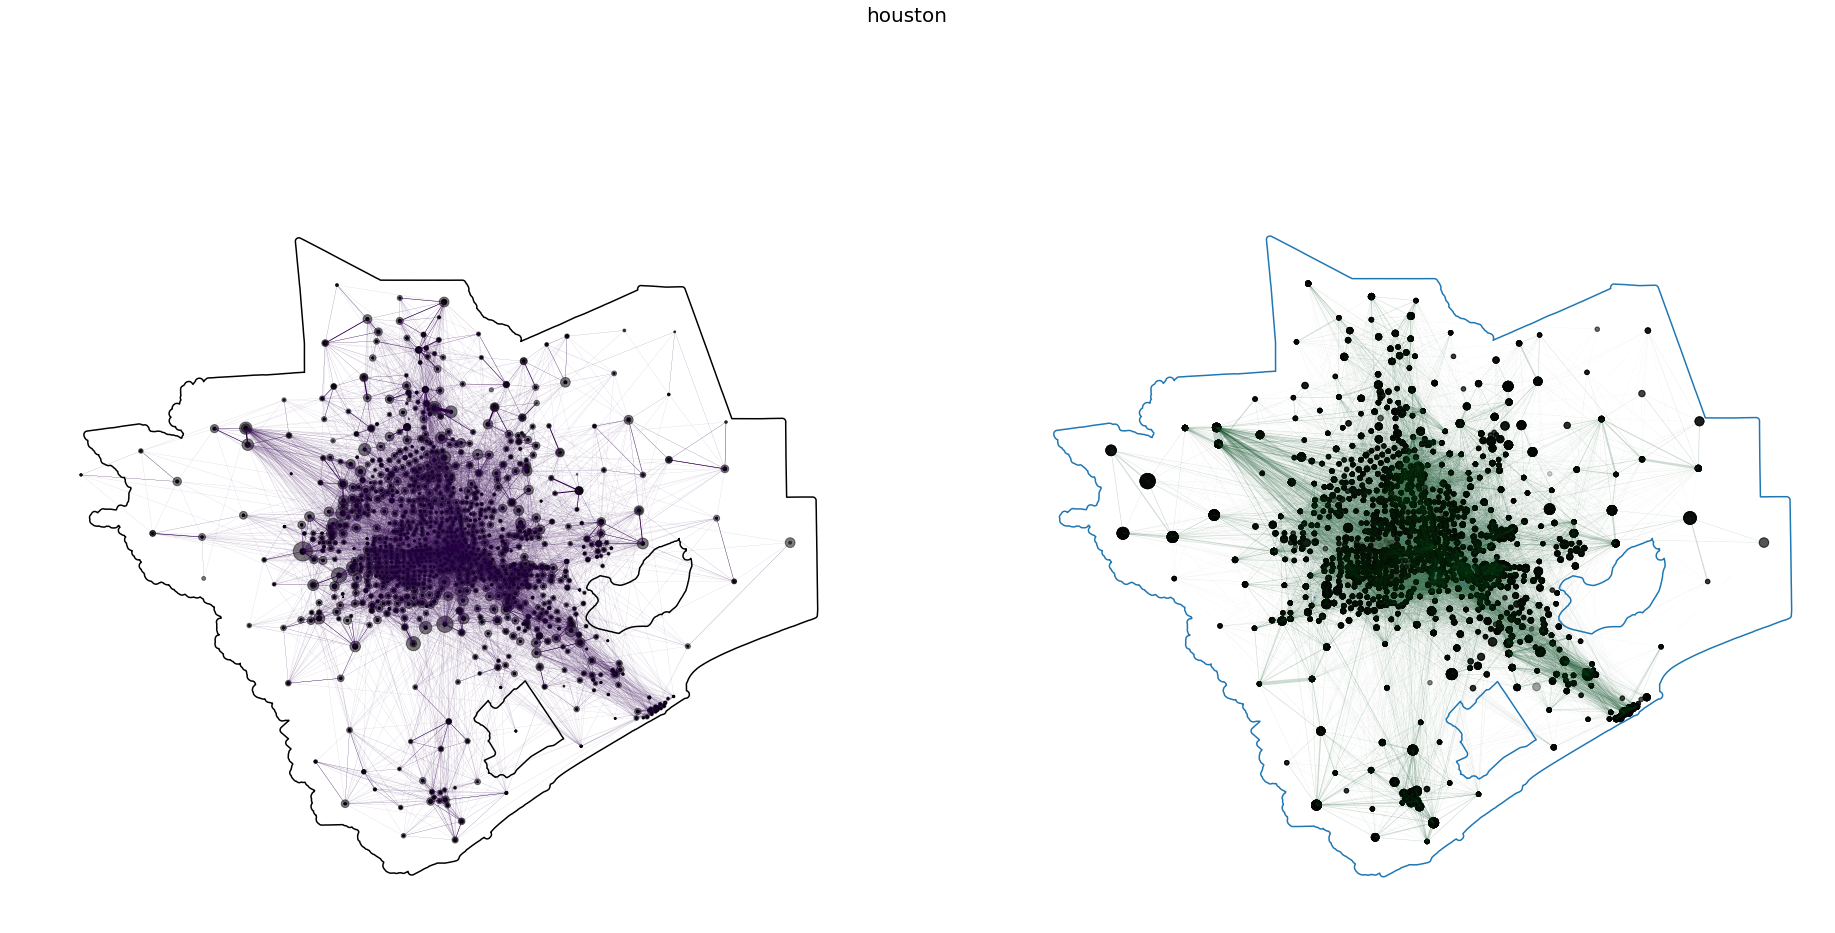

In [63]:
degree_bubble_map('houston', mobility, follow_hh)

# Aggregate plots

In [70]:
# Aggregate dataframe for sorting boxplot drawing

# by network
network_df = tract_df.groupby(['short_name','g_type'])['short_name','g_type','density', 'population_1_city_sum'].mean().reset_index()

# by community
community_df = tract_df.groupby(['short_name', 'g_type', 'algorithm_type', 'S_cons']).mean() # KERDES EZ MMIERT MUKODIK??

In [71]:
# sort by total population
network_df = network_df.sort_values(by=['population_1_city_sum'])

In [72]:
def sorting(df_grouped, by):
    sorted_parts = list(df_grouped.sort_values(by = by, ascending = False).index)
    return sorted_parts

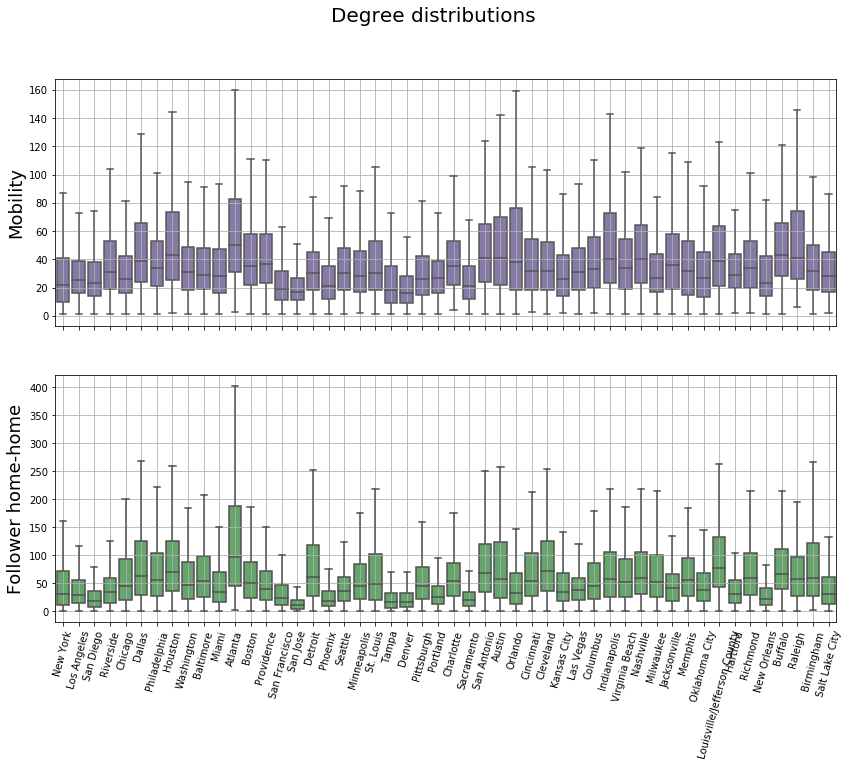

In [75]:
# JAVITANI
fig,ax=plt.subplots(2,1, sharex=True, figsize=(14,10))
fig.suptitle('Degree distributions', fontsize=20)

x = 'short_name' # city
y = 'degree'

#sorted_parts_mob = sorting(community_df[community_df['g_type'] == 'mob'], y)
#sorted_parts_fol_hh = sorting(community_df[community_df['g_type'] == 'fol_hh'], y)

sns.boxplot(ax = ax[0], x = x, y = y, data = tract_df[tract_df['g_type'] == 'mob'], color = color_mob_2, showfliers = False)#.set_xticklabels(labels = tract_df[tract_df['g_type'] == 'mob']['city'], rotation=30) #, order = sorted_parts) #KERDES - UGYANAZOK A SZINEK
# ax[0].set_title('Mobility')
ax[0].set_xlabel('')
#ax[0].set_ylim(0,200)
ax[0].set_ylabel('Mobility', size = 18)
city_l = list(tract_df[tract_df['g_type'] == 'mob']['short_name'].unique()) # KERDES EZT HASZNALHATOM??????
ax[0].set_xticklabels(city_l, rotation = 75)
ax[0].grid()

sns.boxplot(ax = ax[1], x = x, y = y, data = tract_df[tract_df['g_type'] == 'fol_hh'], color = color_fol_hh_2, showfliers = False) #, order = sorted_parts_lw)
#ax[1].set_title('Follower home-home')
ax[1].set_xlabel('')
#ax[1].set_ylim(0,200)
ax[1].set_ylabel('Follower home-home', size = 18)
city_l = list(tract_df[tract_df['g_type'] == 'fol_hh']['short_name'].unique()) # KERDES EZT HASZNALHATOM??????
ax[1].set_xticklabels(city_l, rotation = 75)
ax[1].grid()

In [82]:
a = network_df[network_df['g_type'] == 'mob']['density']
b = network_df[network_df['g_type'] == 'fol_hh']['density']
min_dens = [min(i) for i in zip(a, b)]
max_dens = [max(i) for i in zip(a, b)]

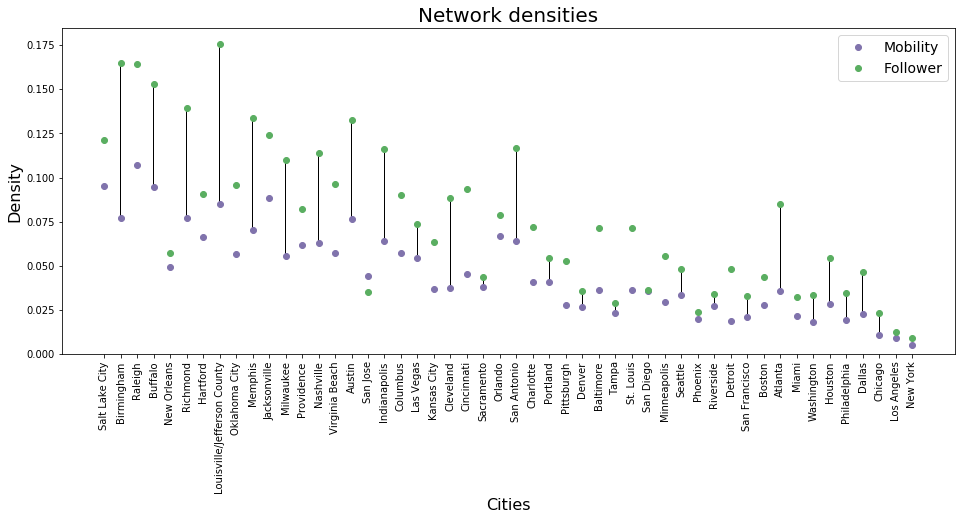

In [97]:
plt.subplots(figsize=(16, 6))

ind = network_df[network_df['g_type'] == 'mob']['short_name']
plt.plot(ind, network_df[network_df['g_type'] == 'mob']['density'], label = 'Mobility', marker='o', linewidth = 0, color = color_mob_2)
plt.plot(ind, network_df[network_df['g_type'] == 'fol_hh']['density'], label = 'Follower', marker='o', linewidth = 0, color = color_fol_hh_2)
plt.bar(ind, max_dens, 0.05, color = 'black')
plt.bar(ind, min_dens, 0.2, color = 'white')


plt.xlabel('Cities', size = 16)
plt.ylabel('Density', size = 16)
plt.legend(loc='upper right', fontsize = 14)
plt.xticks(network_df[network_df['g_type'] == 'mob']['short_name'], rotation = 90) # same order in fol_hh
plt.title('Network densities', size = 20)
plt.show()

In [123]:
# get the number of communities for all cities and both algorithm types
S_max_list_ms = []
S_max_list_mgn = []
for city in city_l:
    S_max_list_ms.append(tract_df[(tract_df['short_name'] == city) & (tract_df['algorithm_type'] == 'ms')]['S_cons'].max()+1)
    S_max_list_mgn.append(tract_df[(tract_df['short_name'] == city) & (tract_df['algorithm_type'] == 'mgn')]['S_cons'].max()+1)

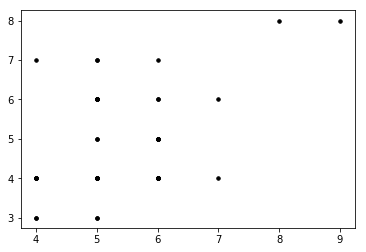

In [124]:
plt.scatter(S_max_list_mgn,S_max_list_ms, color = 'black', s = 12)

In [113]:
tract_df[tract_df['city'] == 'boston']['S_cons'].max()

5

# depreciated

In [31]:
city = 'boston' # should be a clean name - all lowercase, containing '_' instead of ' '

In [32]:
city_mob_ms_df = deepcopy(df[ (df['city'] == city) & (df['g_type'] == 'mob') & (df['algorithm_type'] == 'ms')])
city_mob_mgn_df = deepcopy(df[ (df['city'] == city) & (df['g_type'] == 'mob') & (df['algorithm_type'] == 'mgn')])
city_fol_hh_ms_df = deepcopy(df[ (df['city'] == city) & (df['g_type'] == 'fol_hh') & (df['algorithm_type'] == 'ms')])
city_fol_hh_mgn_df = deepcopy(df[ (df['city'] == city) & (df['g_type'] == 'fol_hh') & (df['algorithm_type'] == 'mgn')])

In [33]:
city_mob_ms_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], city_mob_ms_df, left_on='full_geoid', right_on='geoid')
city_mob_mgn_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], city_mob_mgn_df, left_on='full_geoid', right_on='geoid')
city_fol_hh_ms_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], city_fol_hh_ms_df, left_on='full_geoid', right_on='geoid')
city_fol_hh_mgn_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], city_fol_hh_mgn_df, left_on='full_geoid', right_on='geoid')

city_mob_ms_tracts = city_mob_ms_tracts.drop(columns='full_geoid')
city_mob_mgn_tracts = city_mob_mgn_tracts.drop(columns='full_geoid')
city_fol_hh_ms_tracts = city_fol_hh_ms_tracts.drop(columns='full_geoid')
city_fol_hh_mgn_tracts = city_fol_hh_mgn_tracts.drop(columns='full_geoid')

In [43]:
max(df.S_cons) # --> 9 colors in colormap 

8

### Consensus communities on maps

In [55]:
# uses 9 colors <-- this is the number of communities in the network with most communities
cmap = matplotlib.colors.ListedColormap(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999'])

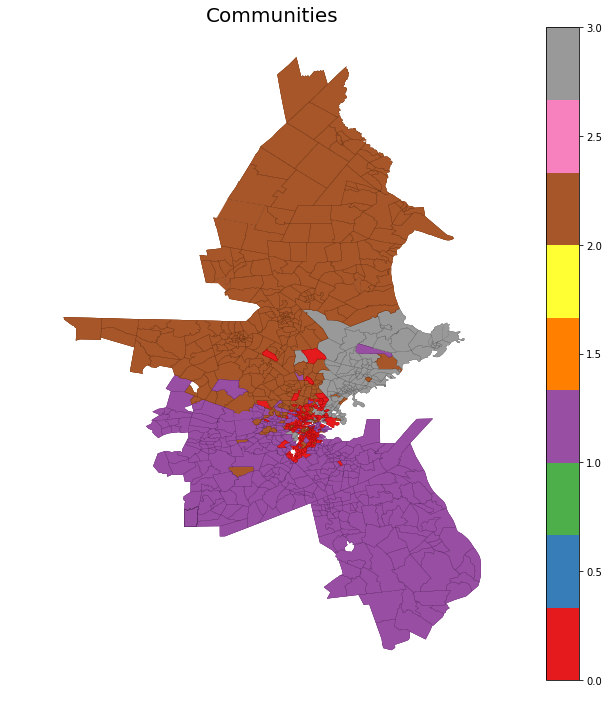

In [56]:
# g_type : mobility
# algorthm_type : Expert

f, ax = plt.subplots(1, figsize=(16,12))
city_mob_ms_tracts.plot(ax=ax, column = 'S_cons', cmap=cmap, legend=True)
city_mob_ms_tracts.boundary.plot(ax=ax, color='black', linewidth=0.015)
#city_mob_mgn_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
ax.set_axis_off()
plt.title('Communities', size=20)
plt.show()

# savefig('consen_communities_mob_ms', dpi=1200, bbox_inches='tight')

In [ ]:
gdf_mobility = GeoDataFrame(mobility, crs="EPSG:4326")
gdf_follow_ww = GeoDataFrame(follow_ww, crs="EPSG:4326")
gdf_follow_hh = GeoDataFrame(follow_hh, crs="EPSG:4326")

In [ ]:
gdf_mobility_home = gdf_mobility.set_geometry('centroid_home')
gdf_mobility_work = gdf_mobility.set_geometry('centroid_work')

In [ ]:
# térképes, pöttyös

f, ax = plt.subplots(1, figsize=(32,16))
boston_tracts_all.boundary.plot(ax=ax)
gdf_mobility.plot(ax=ax, alpha=0.1, linewidth=gdf_mobility['cnt']*0.3, color='black')
gdf_mobility_home.plot(ax=ax, alpha=0.2, markersize=gdf_mobility_home['cnt']*3, color='blue')
gdf_mobility_work.plot(ax=ax, alpha=0.2, markersize=gdf_mobility_work['cnt']*3, color='yellow')
ax.set_axis_off()
plt.show()